In [34]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

from scipy import stats
from sklearn.linear_model import Lasso
from sklearn.preprocessing import normalize

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import OLSInfluence

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

from scipy.optimize import curve_fit

import itertools

In [35]:
# Read the dataset
data_complete = pd.read_excel('world_bank_data.xlsx',header=0,sheet_name='WBD',usecols='A:R')

In [36]:
data_pre=data_complete.iloc[:, [0,1,3,4,7,8,10,13,14,16,17]]
data_pre.head(2)

,Country,Year,Education Expenditure (% of GDP),Electricity Consumption (kWh per capita),GDP per Capita (current US$),Gini Index (Income Inequality),Life Expectancy at Birth (years),Population Growth Rate (%),Poverty Rate (% below $1.90 a day),Unemployment Rate (%),Urbanization Rate (%)
0,Bangladesh,1980,0.9376,95.463663,206.075714,33.0,51.850,2.393149,74.0,4.0,14.851
1,Bangladesh,1981,1.0715,94.949924,224.241392,NaN,52.169,2.564832,NaN,NaN,15.801


In [37]:
Countries = data_pre['Country'].unique()

C:\Users\Kinshuk Mangal\AppData\Local\Temp\ipykernel_26164\990230599.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(method='linear',axis=0,inplace=True)


Country:  United States
Model lag:  3
Predictions:  [41.053 41.129 40.826 41.292 41.575 40.211 40.006 41.061 41.035]
Predict Error:  [-0.147 0.029 -0.374 -0.108 0.075 0.511 0.306 -0.239 -0.265]
    lb_stat  lb_pvalue
1  2.057426   0.151466
Jarque-Bera:  0.8959456427878056
Heteroscedasticity:  0.8438916128319446 



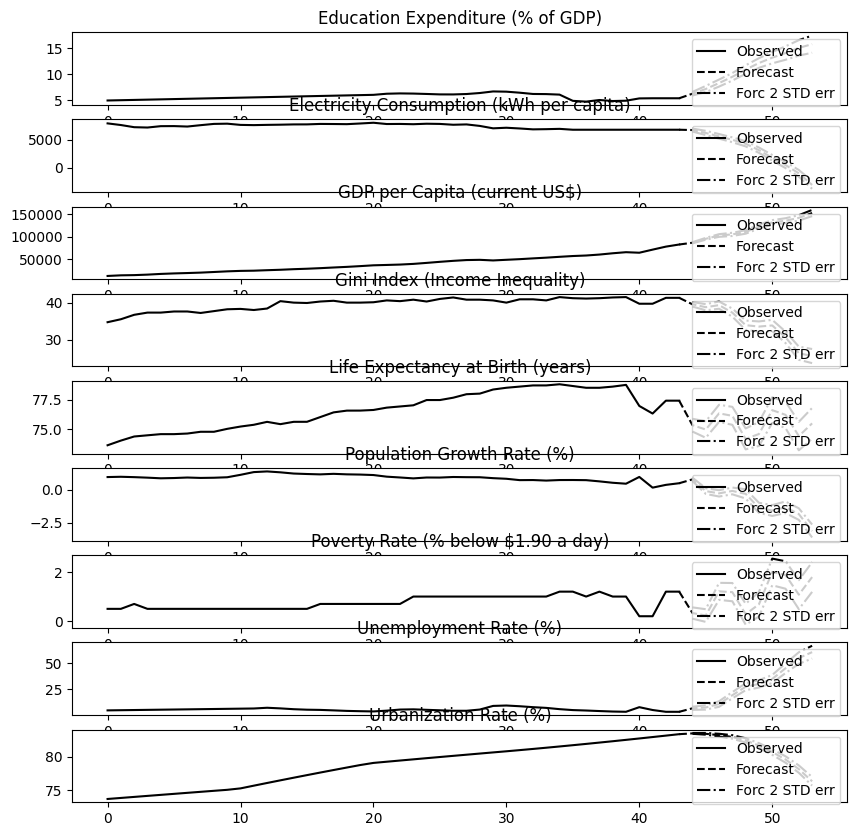

In [91]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

for C in Countries[28:29]:
    # Select the rows from one country 
    data=pd.DataFrame(data_pre[data_pre['Country'] == C])
    
    # Replace the missing inbetween data
    data.interpolate(method='linear',axis=0,inplace=True)
    
    columns_to_drop = data.columns[data.isnull().sum() > 5]
    data = data.drop(columns_to_drop, axis=1)
    df = data.dropna() # Returns a new DataFrame
    df.head(3)
    
    #num_cols = df.shape[1]
    #k0 = num_cols-1 # Number of variables without time
    
    
    VARdata=df.iloc[:, 2:]

    # Dependent variable Gini
    String = "Gini Index (Income Inequality)"
    if String in VARdata.columns:
        Dep = VARdata.columns.get_loc(String)
    else:
        print('Country: ', C)
        print('No', String, '\n')
        continue
        
    num_rows = VARdata.shape[0] # Number of rows
    k=round(num_rows*0.2) # Length of predictions 20%
    k0 = num_rows-k 
    
    VARdata.reset_index(drop=True,inplace=True)
    #model = VAR(VARdata[:k0]); Lags=2 # The model only sees data up to k0. Typically, we need this for forecasting. 
                        # However, in this case, we don’t have enough data to create a model with more than two lags.
    model = VAR(VARdata); Lags=3 # Model with all the data
        
    try:
        results = model.fit(maxlags=Lags, ic='bic')
    except np.linalg.LinAlgError:
        print('Country: ', C)
        print('Error...Skipping \n')
        continue
    lag_order = results.k_ar
    print('Country: ', C)
    print('Model lag: ', lag_order)
    
    # We forecast the last k years using the model, with only the first k0 years of data is given. 
    # While every variable in the VAR model is forecasted, we focus solely on checking the Gini Index forecast.
    A1=results.forecast(VARdata.values[:-k], k)
    A2=VARdata.iloc[-k:,Dep].values
    Err=A1[:,Dep]-A2
    print('Predictions: ', A1[:,Dep])
    print('Predict Error: ', Err)
    #print(results.summary())
    results.plot_forecast(10, alpha=0.05)
    
    
    # Ljung-Box test for Autocorrelation
    test1=sm.stats.acorr_ljungbox(results.resid.iloc[:,Dep], lags=1, return_df=True)
    print(test1)
    
    # Jarque-Bera test for Normality of the residuals
    name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
    test0 = sms.jarque_bera(results.resid.iloc[:,Dep])
    #print(lzip(name, test))
    print('Jarque-Bera: ', test0[1])
    
    # Heteroscedasticity Test
    test2= sm.tsa.stattools.breakvar_heteroskedasticity_test(
        results.resid.iloc[:,Dep], subset_length=0.3333333333333333, alternative='two-sided', use_f=True)
    print('Heteroscedasticity: ', test2[1], '\n')

C:\Users\Kinshuk Mangal\AppData\Local\Temp\ipykernel_26164\3083492987.py:10: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(method='linear', axis=0, inplace=True)


Country:  Bangladesh
Model lag:  3
Predictions (short-term 20% test):  [32.396 32.338 32.395 32.654 32.915 33.102 33.464 33.826 34.302]
Predict Error:  [0.046 -0.062 -0.171 -0.079 0.015 0.035 0.231 0.426 0.902]


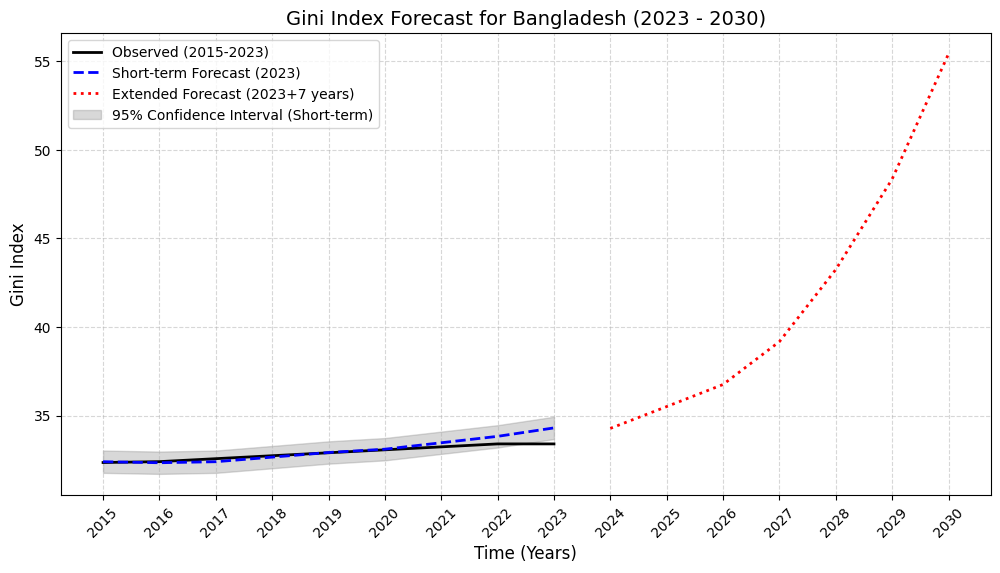

    lb_stat  lb_pvalue
1  0.010928   0.916744
Jarque-Bera:  0.6944758751819453
Heteroscedasticity:  4.420770726074541e-05 

Country:  Brazil
Model lag:  3
Predictions (short-term 20% test):  [52.950 53.075 51.748 52.138 51.886 50.712 51.897 52.941 54.513]
Predict Error:  [1.050 -0.325 -1.552 -1.762 -1.614 1.812 -1.003 0.941 2.513]


C:\Users\Kinshuk Mangal\AppData\Local\Temp\ipykernel_26164\3083492987.py:10: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(method='linear', axis=0, inplace=True)


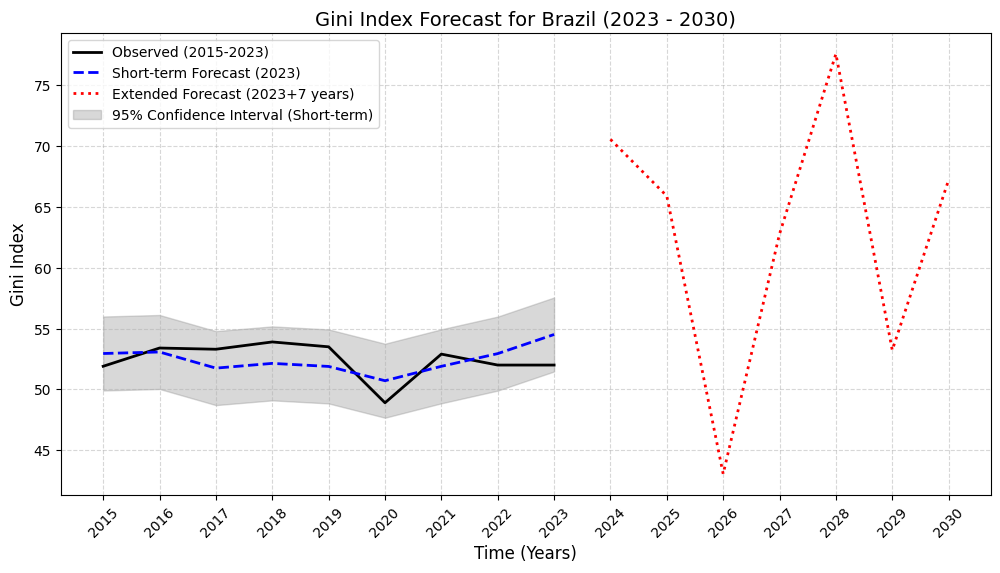

    lb_stat  lb_pvalue
1  3.613271    0.05732
Jarque-Bera:  0.6560359547738082
Heteroscedasticity:  0.04721783063700792 

Country:  China
Model lag:  3
Predictions (short-term 20% test):  [38.614 38.623 38.230 38.463 37.944 37.167 36.121 35.889 34.497]
Predict Error:  [0.014 0.123 -0.870 -0.037 -0.256 0.067 0.421 0.189 -1.203]


C:\Users\Kinshuk Mangal\AppData\Local\Temp\ipykernel_26164\3083492987.py:10: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(method='linear', axis=0, inplace=True)


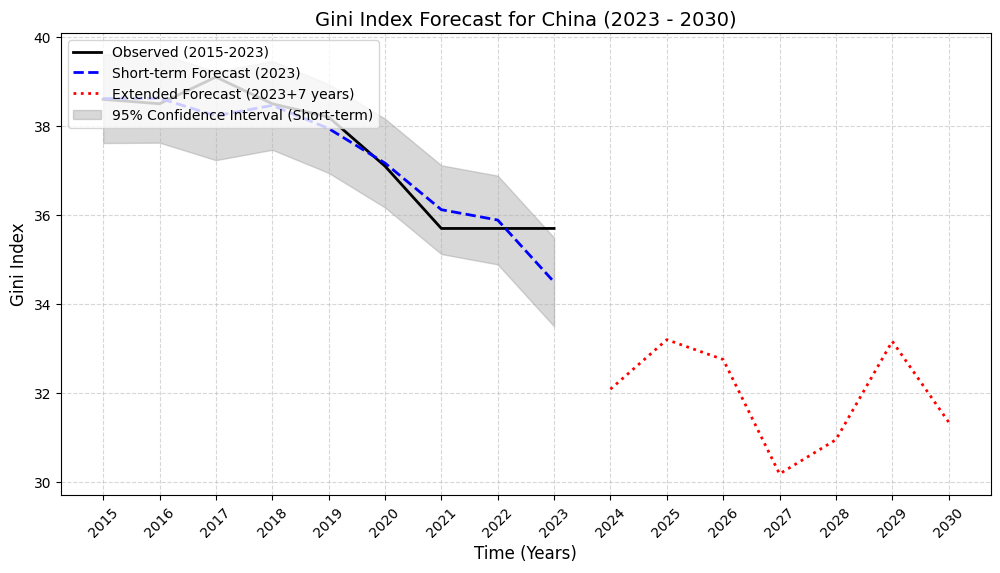

   lb_stat  lb_pvalue
1  0.01082   0.917155
Jarque-Bera:  0.2011622109209425
Heteroscedasticity:  0.387935525053029 



In [39]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

forecast_years = 7  # Define how many extra years to forecast

for C in Countries[0:3]:  # Process the first 3 countries
    # Select data for the country
    data = pd.DataFrame(data_pre[data_pre['Country'] == C])
    
    # Replace missing in-between data
    data.interpolate(method='linear', axis=0, inplace=True)
    
    # Remove columns with too many missing values
    columns_to_drop = data.columns[data.isnull().sum() > 5]
    data = data.drop(columns_to_drop, axis=1)
    df = data.dropna()  # Remove remaining NaNs
    
    # Extract relevant variables for VAR
    VARdata = df.iloc[:, 2:]

    # Identify the dependent variable (Gini Index)
    String = "Gini Index (Income Inequality)"
    if String in VARdata.columns:
        Dep = VARdata.columns.get_loc(String)
    else:
        print('Country: ', C)
        print('No', String, '\n')
        continue

    # Set proper years from 2015-2023
    observed_start_year = 2015
    observed_end_year = 2023
    observed_years = list(range(observed_start_year, observed_end_year + 1))  # Years for observed data

    # Train-test split for forecasting
    num_rows = VARdata.shape[0]
    k = round(num_rows * 0.2)  # 20% of data used for short-term prediction
    k0 = num_rows - k  

    VARdata.reset_index(drop=True, inplace=True)

    # Fit VAR model
    model = VAR(VARdata)
    Lags = 3  # Use 3 lags for the model

    try:
        results = model.fit(maxlags=Lags, ic='bic')
    except np.linalg.LinAlgError:
        print('Country: ', C)
        print('Error...Skipping \n')
        continue

    lag_order = results.k_ar
    print('Country: ', C)
    print('Model lag: ', lag_order)

    # Forecast the last k years using the model (short-term forecast)
    A1 = results.forecast(VARdata.values[:-k], k)  # Forecasted values
    A2 = VARdata.iloc[-k:, Dep].values  # Actual values
    Err = A1[:, Dep] - A2  # Prediction error

    print('Predictions (short-term 20% test): ', A1[:, Dep])
    print('Predict Error: ', Err)

    # === Extended Forecast (future years beyond 2023) ===
    future_forecast = results.forecast(VARdata.values, forecast_years)  # Forecast beyond dataset

    # Create future years for x-axis labels
    future_year_labels = list(range(observed_end_year + 1, observed_end_year + forecast_years + 1))
    past_year_labels = observed_years[-k:]  # Only last 20% for short-term forecast

    # === Improved Graphing Section ===
    fig, ax = plt.subplots(figsize=(12, 6))  # Larger figure for better visualization

    # Plot observed values (2015-2023)
    ax.plot(observed_years[-k:], A2, label="Observed (2015-2023)", color="black", linewidth=2)

    # Plot short-term forecast (2023 estimate)
    ax.plot(past_year_labels, A1[:, Dep], linestyle="dashed", label="Short-term Forecast (2023)", color="blue", linewidth=2)

    # Plot extended forecast beyond 2023
    ax.plot(future_year_labels, future_forecast[:, Dep], linestyle="dotted", label=f"Extended Forecast (2023+{forecast_years} years)", color="red", linewidth=2)

    # Add confidence interval (for short-term forecast errors)
    ax.fill_between(past_year_labels, 
                    A1[:, Dep] - 2 * np.std(Err), 
                    A1[:, Dep] + 2 * np.std(Err), 
                    color="gray", alpha=0.3, label="95% Confidence Interval (Short-term)")

    # Labels and title
    ax.set_title(f"Gini Index Forecast for {C} (2023 - {2023 + forecast_years})", fontsize=14)
    ax.set_xlabel("Time (Years)", fontsize=12)
    ax.set_ylabel("Gini Index", fontsize=12)

    # Adjust x-axis ticks for better spacing
    all_years_labels = past_year_labels + future_year_labels  # Combine past & future years
    ax.set_xticks(all_years_labels[::max(1, len(all_years_labels) // 10)])  # Select a reasonable number of x-ticks
    ax.tick_params(axis='x', rotation=45, labelsize=10)

    # Improve legend positioning
    ax.legend(loc="upper left", fontsize=10, frameon=True)

    # Add gridlines for clarity
    ax.grid(True, linestyle="--", alpha=0.5)

    # Show the improved forecast plot
    plt.show()

    # === Diagnostic Tests ===
    # Ljung-Box test for Autocorrelation
    test1 = sm.stats.acorr_ljungbox(results.resid.iloc[:, Dep], lags=1, return_df=True)
    print(test1)

    # Jarque-Bera test for Normality of the residuals
    test0 = sms.jarque_bera(results.resid.iloc[:, Dep])
    print('Jarque-Bera: ', test0[1])

    # Heteroscedasticity Test
    test2 = sm.tsa.stattools.breakvar_heteroskedasticity_test(
        results.resid.iloc[:, Dep], subset_length=0.3333333333333333, alternative='two-sided', use_f=True)
    print('Heteroscedasticity: ', test2[1], '\n')

Country: India
Model lag: 3
Predictions: [4.101 4.276 4.299 4.259 3.953 4.222 4.801 3.738 4.854]
Prediction Error: [-0.014 0.019 -0.007 -0.118 0.056 0.182 0.166 -0.383 0.733]


C:\Users\Kinshuk Mangal\AppData\Local\Temp\ipykernel_26164\2968159342.py:9: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(method='linear', axis=0, inplace=True)


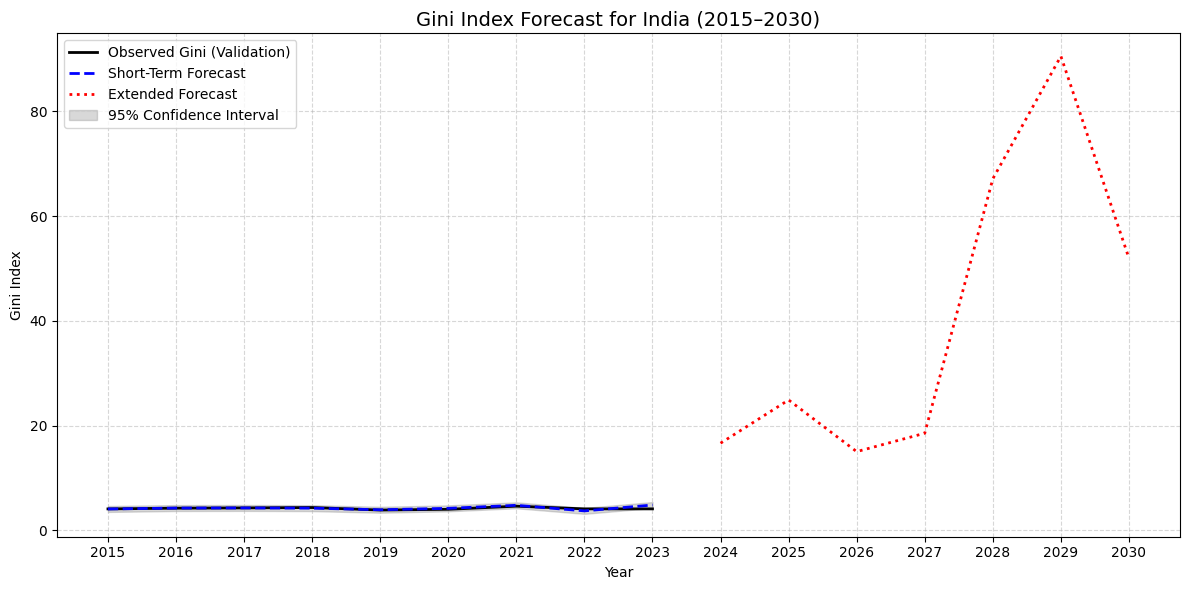

In [13]:
# Display floats neatly
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

# === Loop through selected country ===
for C in Countries[9:10]:  # Change index for other countries (e.g., [1:2] for India)
    
    # Step 1: Load and preprocess data
    data = data_pre[data_pre['Country'] == C].copy()
    data.interpolate(method='linear', axis=0, inplace=True)
    columns_to_drop = data.columns[data.isnull().sum() > 5]
    data = data.drop(columns_to_drop, axis=1)
    df = data.dropna()
    
    # Step 2: Select relevant variables (excluding Country/Year)
    VARdata = df.iloc[:, 2:].copy()
    VARdata.reset_index(drop=True, inplace=True)
    
    # Step 3: Identify Gini column
    String = "Education Expenditure (% of GDP)"
    if String in VARdata.columns:
        Dep = VARdata.columns.get_loc(String)
    else:
        print('Country:', C)
        print('No', String, '\n')
        continue

    # Step 4: Forecasting Setup
    num_rows = VARdata.shape[0]
    k = round(num_rows * 0.2)
    k0 = num_rows - k

    model = VAR(VARdata)
    Lags = 3

    # Step 5: Fit model
    try:
        results = model.fit(maxlags=Lags, ic='bic')
    except np.linalg.LinAlgError:
        print('Country:', C)
        print('Fitting error...Skipping\n')
        continue

    lag_order = results.k_ar
    print('Country:', C)
    print('Model lag:', lag_order)

    # Step 6: Short-term (validation) forecast
    A1 = results.forecast(VARdata.values[:-k], k)
    A2 = VARdata.iloc[-k:, Dep].values
    Err = A1[:, Dep] - A2
    print('Predictions:', A1[:, Dep])
    print('Prediction Error:', Err)

    # Step 7: Long-term (extended) forecast
    forecast_years = 7
    A_future = results.forecast(VARdata.values, forecast_years)

    # Step 8: Visualization
    observed_end_year = 2023
    observed_start_year = observed_end_year - k + 1
    past_years = list(range(observed_start_year, observed_end_year + 1))
    future_years = list(range(observed_end_year + 1, observed_end_year + forecast_years + 1))

    plt.figure(figsize=(12, 6))
    
    # Plot observed Gini values (validation)
    plt.plot(past_years, A2, label="Observed Gini (Validation)", color="black", linewidth=2)
    
    # Plot short-term forecast
    plt.plot(past_years, A1[:, Dep], linestyle="--", label="Short-Term Forecast", color="blue", linewidth=2)

    # Plot extended forecast
    plt.plot(future_years, A_future[:, Dep], linestyle=":", label="Extended Forecast", color="red", linewidth=2)

    # Add confidence interval for short-term error
    ci = 2 * np.std(Err)
    plt.fill_between(past_years,
                     A1[:, Dep] - ci,
                     A1[:, Dep] + ci,
                     color="gray", alpha=0.3, label="95% Confidence Interval")

    plt.title(f"Gini Index Forecast for {C} (2015–{future_years[-1]})", fontsize=14)
    plt.xlabel("Year")
    plt.ylabel("Gini Index")
    plt.xticks(past_years + future_years[::max(1, len(future_years)//6)])
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(loc="upper left", fontsize=10)
    plt.tight_layout()
    plt.show()


Country: India


C:\Users\Kinshuk Mangal\AppData\Local\Temp\ipykernel_26164\1714038714.py:10: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(method='linear', axis=0, inplace=True)


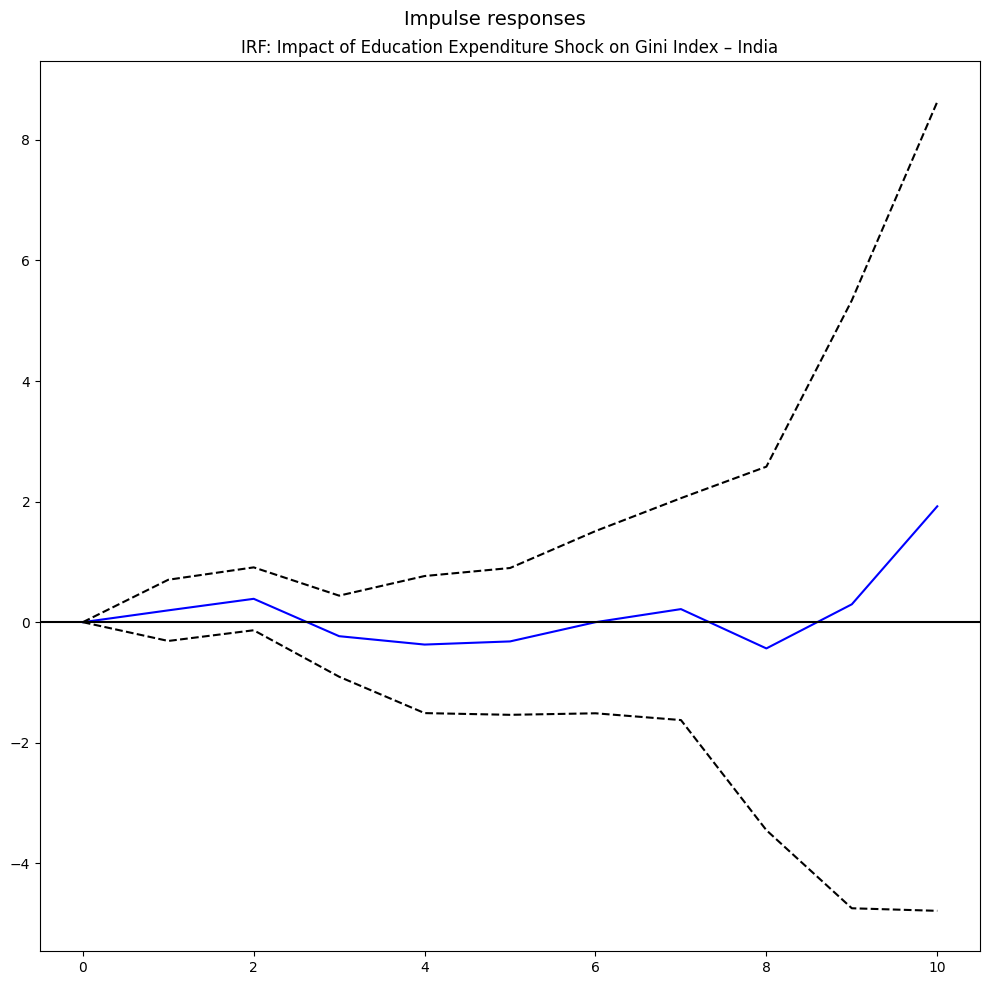

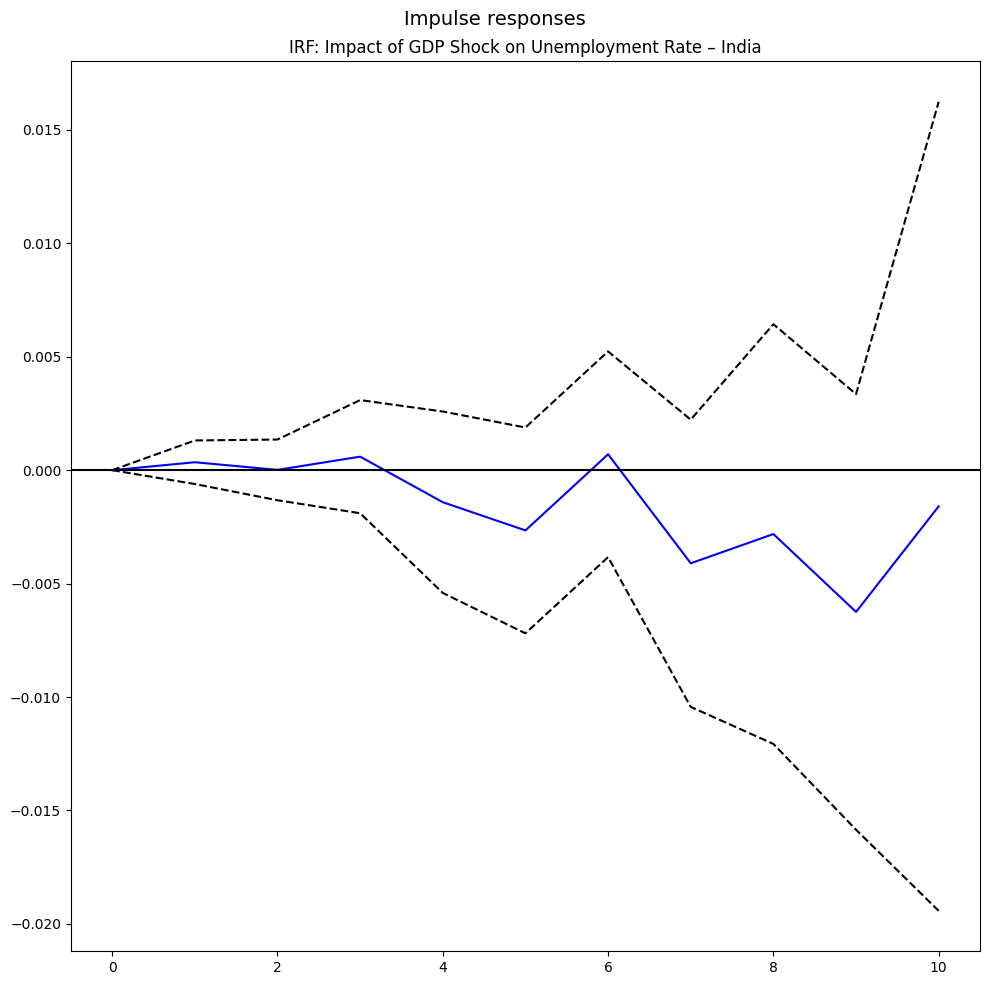

In [21]:
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

for C in Countries[9:10]:  # Change to [1:2] for India
    print('Country:', C)

    # === 1. Data Preparation ===
    data = pd.DataFrame(data_pre[data_pre['Country'] == C])
    data.interpolate(method='linear', axis=0, inplace=True)
    columns_to_drop = data.columns[data.isnull().sum() > 5]
    data = data.drop(columns_to_drop, axis=1)
    df = data.dropna()

    # === 2. Subset to variables only (excluding Country, Year) ===
    VARdata = df.iloc[:, 2:]
    VARdata.reset_index(drop=True, inplace=True)

    # === 3. Fit VAR model ===
    model = VAR(VARdata)
    Lags = 3  # Use maxlags = 3 for stability

    try:
        results = model.fit(maxlags=Lags, ic='bic')
    except:
        print("VAR fitting failed, skipping...\n")
        continue

    # === 4. Generate IRFs ===
    irf = results.irf(10)  # 10-period horizon

    # === Plot 1: Education Expenditure → Gini Index ===
    try:
        irf.plot(impulse='Education Expenditure (% of GDP)', response='Gini Index (Income Inequality)', orth=False)
        plt.title(f"IRF: Impact of Education Expenditure Shock on Gini Index – {C}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Failed to plot Education → Gini IRF for {C}. Reason: {e}")

    # === Plot 2: GDP → Unemployment Rate ===
    try:
        irf.plot(impulse='GDP per Capita (current US$)', response='Unemployment Rate (%)', orth=False)
        plt.title(f"IRF: Impact of GDP Shock on Unemployment Rate – {C}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Failed to plot GDP → Unemployment IRF for {C}. Reason: {e}")


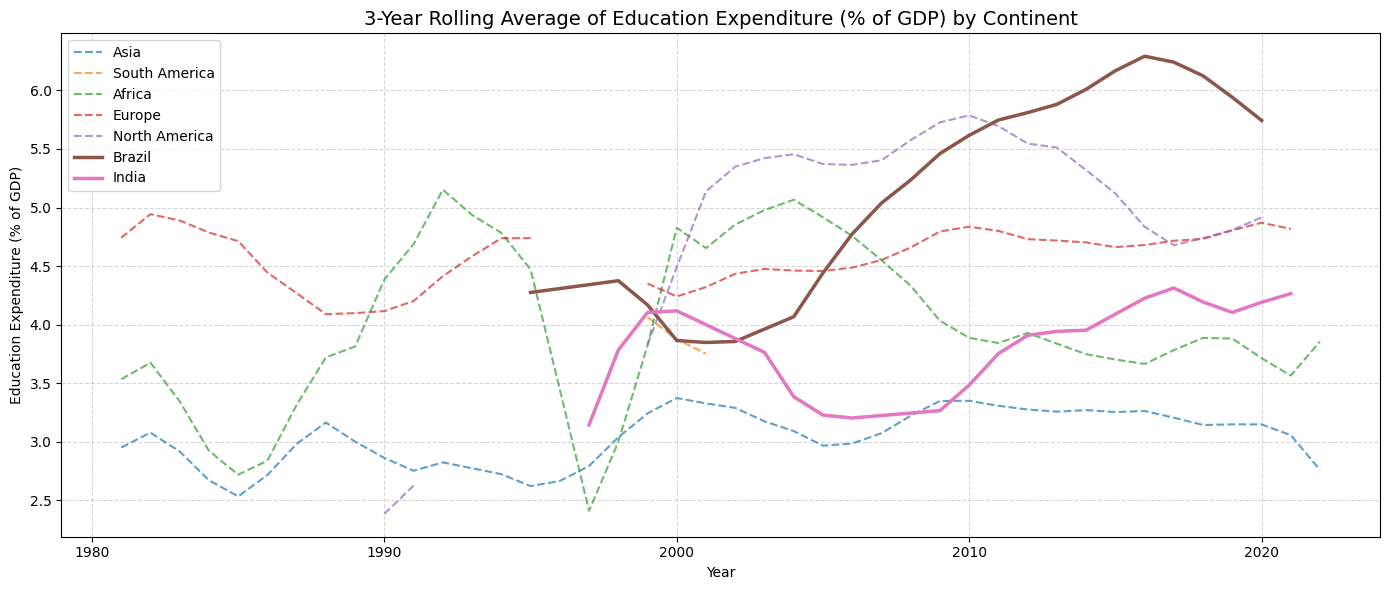

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
file_path = 'world_bank_data.xlsx'
data_pre = pd.read_excel(file_path, sheet_name='WBD')

# Mapping countries to continents (based on your dataset)
continent_map = {
    'Bangladesh': 'Asia', 'Brazil': 'South America', 'China': 'Asia', 'Colombia': 'South America',
    'Congo, Dem. Rep.': 'Africa', 'Egypt, Arab Rep.': 'Africa', 'Ethiopia': 'Africa', 'France': 'Europe',
    'Germany': 'Europe', 'India': 'Asia', 'Indonesia': 'Asia', 'Iran, Islamic Rep.': 'Asia',
    'Italy': 'Europe', 'Japan': 'Asia', 'Kenya': 'Africa', 'Korea, Rep.': 'Asia',
    'Mexico': 'North America', 'Myanmar': 'Asia', 'Nigeria': 'Africa', 'Pakistan': 'Asia',
    'Philippines': 'Asia', 'Russian Federation': 'Europe', 'South Africa': 'Africa', 'Spain': 'Europe',
    'Tanzania': 'Africa', 'Thailand': 'Asia', 'Turkiye': 'Asia', 'United Kingdom': 'Europe',
    'United States': 'North America', 'Viet Nam': 'Asia'
}

data_pre['Continent'] = data_pre['Country'].map(continent_map)

# Rolling average comparison setup
target_variable = 'Education Expenditure (% of GDP)'
highlight_countries = ['Brazil', 'India']
window_size = 3

plt.figure(figsize=(14, 6))

# Plot continent-level rolling averages
for continent in data_pre['Continent'].dropna().unique():
    group = data_pre[data_pre['Continent'] == continent]
    grouped = group.groupby(['Year'])[target_variable].mean().rolling(window=window_size, center=True).mean()
    plt.plot(grouped.index, grouped.values, label=continent, linestyle='dashed', alpha=0.7)

# Highlight Brazil and India
for country in highlight_countries:
    country_data = data_pre[data_pre['Country'] == country][['Year', target_variable]].dropna()
    if not country_data.empty:
        rolling_avg = country_data.sort_values('Year')[target_variable].rolling(window=window_size, center=True).mean()
        plt.plot(country_data['Year'], rolling_avg, label=country, linewidth=2.5)

# Formatting the plot
plt.title(f"{window_size}-Year Rolling Average of {target_variable} by Continent", fontsize=14)
plt.xlabel("Year")
plt.ylabel(target_variable)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


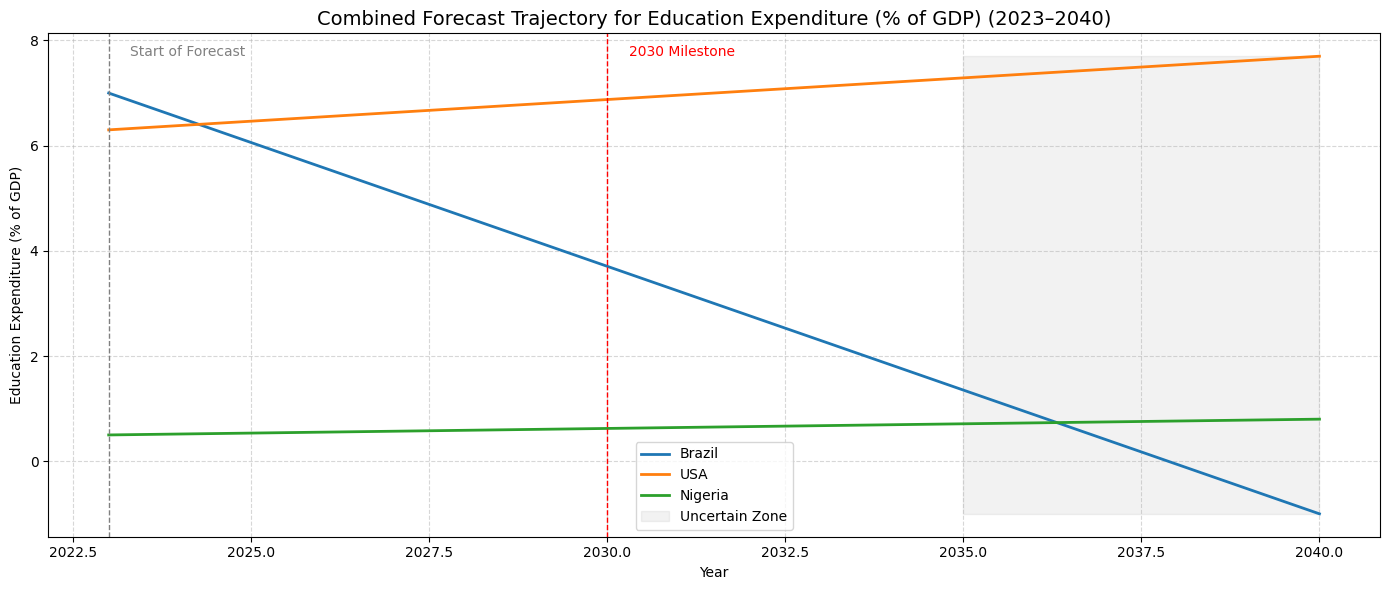

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Example structure: replace with actual forecasted values from your VAR model for the selected variable
years = list(range(2023, 2041))
forecast_data = {
    'Brazil': np.linspace(7,-1, len(years)),       # Replace with real forecast data
    #'India': np.linspace(5, -1847, len(years)),
    'USA': np.linspace(6.3, 7.7, len(years)),
    'Nigeria': np.linspace(0.5, 0.8, len(years)),
    #'China': np.linspace(17, 9152, len(years)),
}
df_forecast = pd.DataFrame(forecast_data, index=years)

# === PLOT ===
plt.figure(figsize=(14, 6))
for country in df_forecast.columns:
    plt.plot(df_forecast.index, df_forecast[country], label=country, linewidth=2)

# Milestone lines and annotation
plt.axvline(x=2023, color='gray', linestyle='--', linewidth=1)
plt.text(2023.3, df_forecast.max().max(), 'Start of Forecast', color='gray')

plt.axvline(x=2030, color='red', linestyle='--', linewidth=1)
plt.text(2030.3, df_forecast.max().max(), '2030 Milestone', color='red')

# Uncertainty highlight
plt.fill_betweenx([df_forecast.min().min(), df_forecast.max().max()],
                  2035, 2040, color='gray', alpha=0.1, label='Uncertain Zone')

# Titles and labels
plt.title("Combined Forecast Trajectory for Education Expenditure (% of GDP) (2023–2040)", fontsize=14)  # <- Update title per variable
plt.xlabel("Year")
plt.ylabel("Education Expenditure (% of GDP)")  # <- Update y-label per variable
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [83]:
from statsmodels.tsa.api import VAR
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.stats.api as sms

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

# Set up
forecast_years = 18  # 2023–2040
target_variable = "Education Expenditure (% of GDP)"  # Change this as needed

for C in Countries[28:29]:  # Replace with [0:1] for Brazil, etc.
    print(f"=== VAR Forecast for {C} ===")

    # Step 1: Prepare the data
    data = pd.DataFrame(data_pre[data_pre['Country'] == C])
    data.interpolate(method='linear', axis=0, inplace=True)
    columns_to_drop = data.columns[data.isnull().sum() > 5]
    data = data.drop(columns_to_drop, axis=1)
    df = data.dropna()
    df.head(3)

    # Step 2: Prepare VAR data
    VARdata = df.iloc[:, 2:].reset_index(drop=True)

    # Step 3: Get dependent variable index
    if target_variable in VARdata.columns:
        Dep = VARdata.columns.get_loc(target_variable)
    else:
        print(f"{target_variable} not found for {C}, skipping...\n")
        continue

    # Step 4: Forecasting prep
    num_rows = VARdata.shape[0]
    k = round(num_rows * 0.2)
    k0 = num_rows - k

    # Step 5: Fit VAR model
    model = VAR(VARdata)
    try:
        results = model.fit(maxlags=3, ic='bic')
    except np.linalg.LinAlgError:
        print(f"{C}: VAR fitting failed. Skipping...\n")
        continue

    lag_order = results.k_ar
    print(f"Model lag selected: {lag_order}")

    # Step 6: Long-term forecast
    future_forecast = results.forecast(VARdata.values, steps=forecast_years)
    start_value = future_forecast[0, Dep]     # Forecast for 2023
    end_value = future_forecast[-1, Dep]      # Forecast for 2040

    print(f"{C} — {target_variable}")
    print(f"Start (2023): {start_value:.3f}")
    print(f"End (2040): {end_value:.3f}\n")


=== VAR Forecast for United States ===
Model lag selected: 3
United States — Education Expenditure (% of GDP)
Start (2023): 6.305
End (2040): 7.696



C:\Users\Kinshuk Mangal\AppData\Local\Temp\ipykernel_26164\4255854747.py:18: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(method='linear', axis=0, inplace=True)
